<a href="https://colab.research.google.com/github/AmirRezaEskandarani/Farsi_handwritten_digits_recognition-/blob/main/Farsi_handwritten_digits_recognition_LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognize Farsi digits from 0 to 9

In [1]:
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical

### mount google drive to load data from my drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Function to load dataset

In [3]:
# *-* coding: utf-8 *-*

# Hoda Dataset Reader
# Python code for reading Hoda farsi digit dataset.

# Hoda Farsi Digit Dataset:
# http://farsiocr.ir/
# http://farsiocr.ir/مجموعه-داده/مجموعه-ارقام-دستنویس-هدی
# http://dadegan.ir/catalog/hoda

# Repository:
# https://github.com/amir-saniyan/HodaDatasetReader

import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255.0
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

### load train data

In [4]:
X_train, y_train = read_hoda_dataset('/content/drive/MyDrive/Data mining/Farsi digits/Train 60000.cdb')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### load test data

In [5]:
X_test, y_test = read_hoda_dataset('/content/drive/MyDrive/Data mining/Farsi digits/Test 20000.cdb')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### take validation data from train data

In [6]:
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

In [7]:
X_val.shape

(10000, 1024)

In [8]:
def display_image(position):
  image = train['features'][position].squeeze()
  plt.title(f'Example {position}. Label: {train["labels"][position]}')
  plt.imshow(image, cmap=plt.cm.gray_r)

### reshape to be [samples][width][height][channels]

In [9]:
X_train = X_train.reshape((X_train.shape[0], 32, 32, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 32, 32, 1)).astype('float32')
X_val = X_val.reshape((X_val.shape[0], 32, 32, 1)).astype('float32')

In [10]:
X_train.shape

(50000, 32, 32, 1)

In [11]:
X_test.shape

(20000, 32, 32, 1)

In [12]:
X_val.shape

(10000, 32, 32, 1)

###  one hot encode outputs and get number fo classes

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
# num_classes = y_test.shape[1]

### define and compile the model

In [14]:
def cnn_model_LeNet_5():

  lenet_5_model = Sequential()
  lenet_5_model.add(Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(32, 32, 1), padding='same')) #C1
  lenet_5_model.add(AveragePooling2D()) #S2
  lenet_5_model.add(Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid')) #C3
  lenet_5_model.add(AveragePooling2D()) #S4
  lenet_5_model.add(Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid')) #C5
  lenet_5_model.add(Flatten()) #Flatten    
  lenet_5_model.add(Dense(84, activation='tanh')) #F6
  lenet_5_model.add(Dense(10, activation='softmax')) #Output layer
  lenet_5_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return lenet_5_model

model = cnn_model_LeNet_5()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 480)               0

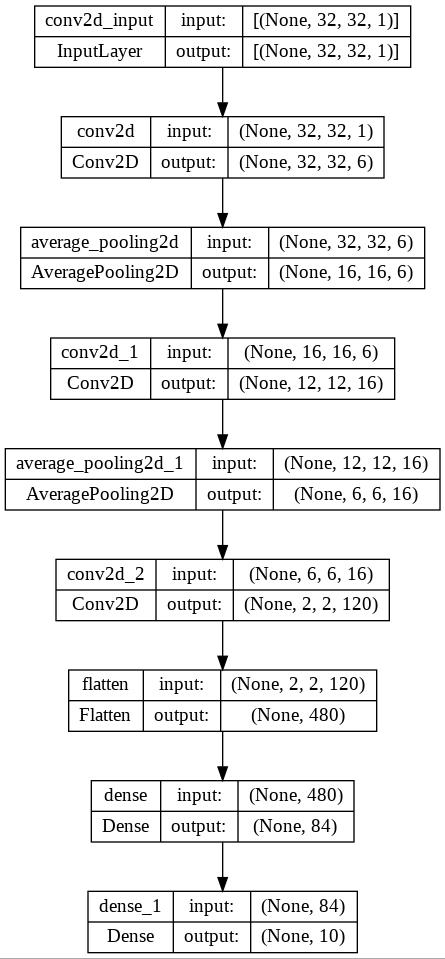

In [16]:
plot_model(model, 'model.jpg', show_shapes=True)

### Fit the model


In [17]:
X_val.shape

(10000, 32, 32, 1)

### use early stop to avoid overfitting

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=128, callbacks=[checkpoint_cb, early_stopping_cb])
model = keras.models.load_model('./model/model.h5')


Epoch 1/20
391/391 [==============================] - 12s 7ms/step - loss: 0.1960 - accuracy: 0.9451 - val_loss: 0.0765 - val_accuracy: 0.9768
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 0.0669 - accuracy: 0.9801 - val_loss: 0.0606 - val_accuracy: 0.9819
Epoch 3/20
391/391 [==============================] - 4s 11ms/step - loss: 0.0461 - accuracy: 0.9863 - val_loss: 0.0473 - val_accuracy: 0.9860
Epoch 4/20
391/391 [==============================] - 3s 7ms/step - loss: 0.0372 - accuracy: 0.9890 - val_loss: 0.0412 - val_accuracy: 0.9874
Epoch 5/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0279 - accuracy: 0.9917 - val_loss: 0.0327 - val_accuracy: 0.9907
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.0240 - accuracy: 0.9926 - val_loss: 0.0402 - val_accuracy: 0.9881
Epoch 7/20
391/391 [==============================] - 2s 6ms/step - loss: 0.0208 - accuracy: 0.9935 - val_loss: 0.0312 - val_accuracy: 0.9909
Epoc

### calculate loss and accuray of the model

In [19]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'loss for the model is {loss} \naccuracy for the model is {accuracy}')

loss for the model is 0.046504899859428406 
accuracy for the model is 0.9886500239372253


### plot training and validation accuracy

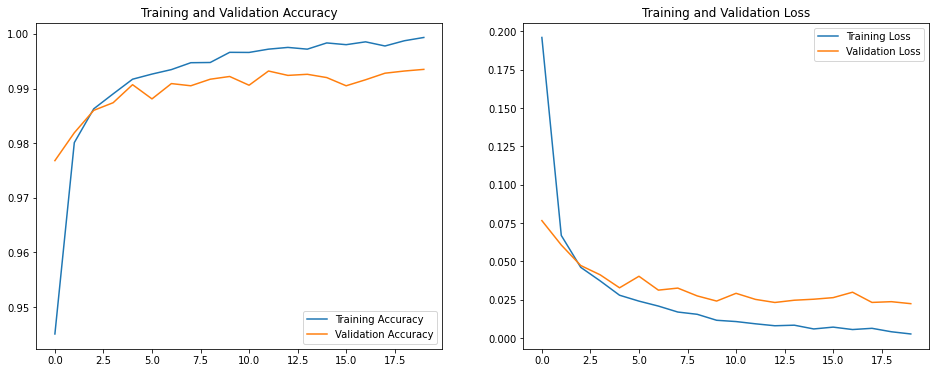

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()